In [1]:
import pandas as pd
import json
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
import simplemma
from tqdm import tqdm
import numpy as np
from syntok.tokenizer import Tokenizer
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from gensim.models import FastText, KeyedVectors

In [849]:
import pickle

In [ ]:
# from tokenizers import Tokenizer
# from tokenizers.models import BPE, Unigram, WordLevel, WordPiece
# from tokenizers.trainers import BpeTrainer, WordLevelTrainer, \
#                                 WordPieceTrainer, UnigramTrainer

## EDA

In [2]:
with open('data/agora_hack_products.json') as f:
    train_dataset = json.load(f)

In [3]:
len(train_dataset)

3251

In [1295]:
random.choices(non_reference_ids, k=10)

TypeError: unhashable type: 'list'

In [4]:
all([x.keys().__len__() == 5 for x in train_dataset])

True

In [5]:
len(set([x['product_id'] for x in train_dataset])) == len(train_dataset)

True

In [1090]:
random.choices(train_dataset, k=5)

[{'product_id': 'f72faaa81bcf61a2',
  'name': 'Монитор Dell 23.8"" P2418HZm черный IPS LED 16:9 HDMI DisplayPort M/M Cam Mat HAS Pivot 1000:1 250cd',
  'props': ['Покрытие  экрана антибликовое, матовое',
   'Интерфейсы вход HDMI, вход DisplayPort, вход VGA'],
  'is_reference': False,
  'reference_id': 'ae0ded178481d783'},
 {'product_id': '9fb7c3c82eca3de8',
  'name': 'Фен Lumme LU-1058 фиолетовый',
  'props': ['Мощность\t1400  Вт',
   'Особенности  складная ручка, защита от перегрева, петля для подвешивания'],
  'is_reference': False,
  'reference_id': '0083737f904dd9a9'},
 {'product_id': 'a194d0e01810cef4',
  'name': 'KORTING Посудомоечная машина KORTING KDI 45570',
  'props': ['Тип   защиты от протечек\tполная',
   'Индикация на полу\tлуч',
   'Ширина\t45 см',
   'Третий  уровень загрузки\tесть',
   'Вместимость\t10   комплектов'],
  'is_reference': False,
  'reference_id': 'f325184a5c99c599'},
 {'product_id': 'f5949f3c3d4611af',
  'name': '43" Телевизор LG 43UP75006LF 2021 LED, HDR,

In [7]:
train_dict = {x['product_id']: x for x in train_dataset}
len(train_dict)

3251

In [1290]:
"Особенности\tблокировка   от детей".split('\t', maxsplit=1)

['Особенности', 'блокировка  \t от детей']

In [8]:
reference_ids = set([x for x, y in train_dict.items() if y['is_reference']])
len(reference_ids)

471

In [9]:
non_reference_ids = set([x for x, y in train_dict.items() if not y['is_reference']])
len(non_reference_ids)

2780

In [10]:
per_ref_counter = Counter()
for x in train_dataset:
    per_ref_counter[x['reference_id']] += 1
per_ref_counter.most_common(5)

[(None, 471),
 ('116c9e6140857b4b', 37),
 ('d4ebc4a26700d5e0', 34),
 ('b91a686bdeee3b59', 22),
 ('d7d28d1201ba8bde', 22)]

Text(0.5, 1.0, 'Количество ссыланий на референсы')

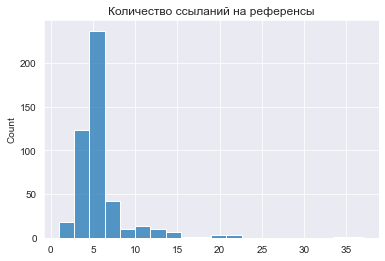

In [11]:
sns.histplot([x[1] for x in per_ref_counter.items() if x[0] is not None], bins=20).set_title('Количество ссыланий на референсы')

In [12]:
for i, (id, c) in enumerate(per_ref_counter.most_common(31)[1:]):
    print(f'{i + 1} ({c}). {train_dict[id]["name"]}')

1 (37). Газовая плита GEFEST 700-02, коричневый
2 (34). Робот-пылесос Xiaomi Mi Robot Vacuum-Mop 2 Lite RU, белый
3 (22). Робот-пылесос Xiaomi Viomi Cleaning robot, black
4 (22). Встраиваемая посудомоечная машина Candy CDIH 2L1047-08
5 (21). Встраиваемая посудомоечная машина Candy CDIH 1L949-08
6 (20). Электрическая плита Energy EN-904В, черный
7 (20). Индукционная плита Hyundai HYC-0101, черный
8 (19). Сплит-система Royal Clima RC-PD28HN, белый
9 (18). 16.1" Ноутбук HONOR MagicBook 16 1920x1080, AMD Ryzen 5 5600H 3.3 ГГц, SSD 512 ГБ, HDD отсутствует, AMD Radeon Graphics, Windows 11 Home, 5301ABCM, космический серый
10 (16). Mi Robot Vacuum-Mop 2 Pro
11 (15). Индукционная плита Gorenje 566815, черный
12 (15). Встраиваемая посудомоечная машина Korting KDI 45570, серебристый
13 (15). Встраиваемая посудомоечная машина Gorenje GV62040, белый
14 (15). Робот-пылесос Xiaomi Mi Robot Vacuum-Mop 2 Ultra EU, черный
15 (14). Робот-пылесос Xiaomi Viomi Cleaning Robot V3, черный
16 (14). Индукционн

Text(0.5, 1.0, 'Количество пропсов')

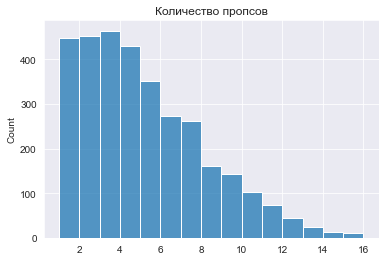

In [13]:
sns.histplot([len(x['props']) for x in train_dataset], bins=15).set_title('Количество пропсов')

## Preprocessing

In [1176]:
clear_string = lambda x: re.sub(' +', ' ', re.sub(r"[^а-яА-Яa-zA-Z\d\s\,.:!?]", "", x.replace('\t', ': ').replace('-', ' - ').replace('/', ' / '))).strip()

In [1177]:
combined_dict = dict()
for (id, x) in train_dict.items():
    combined_dict[id] = clear_string(x['name']) + " | " + clear_string(" ".join(x['props']))
random.choices(list(combined_dict.items()), k=5)

[('206e6152baa06f26',
  'Кондиционер Electrolux EACS 09HAT N3 Комплект | Доп. режимы ночной, осушение, вентиляция'),
 ('116a0dea1a4ff02d',
  'Накопительный электрический водонагреватель Thermex Omnia 80 V, белый | Покрытие бака: стеклокерамика Управление: механическое Функции: ускоренный нагрев Объем бака: 80 л Потребляемая мощность: 2000 Вт Полезная мощность: 2 кВт Максимальная температура воды: 75 С Время нагрева: 100 мин Размеры ШxВxГ: 542x963x329 мм Системы защиты: предохранительный клапан Индикация нагрева, включения Установка: вертикальная на стену с нижней подводкой'),
 ('a2c0fc2cc9ed2d14',
  'Фен Lumme LU 1057 Blue Sapphire | Мощность: 1400 Вт Вес: 350 г'),
 ('8b69cc8b592abddf',
  'Кофемашина Beko CEG5311X | Особенности конструкции съемный лоток для сбора капель, индикатор уровня воды, индикатор включения, контейнер для отходов, дисплей Тип используемого кофе: зерновой Давление помпы: 19 бар Приготовление капучино: ручное Количество степеней помола: 5 Тип напитка латте, капучин

In [16]:
def tokenize_text(text: str, lemmatize=True, tokenizer=Tokenizer()) -> list:
    tokens = [token.value for token in tokenizer.tokenize(text)]
    if lemmatize:
        tokens = [simplemma.lemmatize(token, lang=('en', 'ru')).lower() for token in tokens if token]
    return tokens

## CountVectorizer and TF-IDF

In [1229]:
only_refs_texts = list(map(lambda x: x[1], filter(lambda x: x[0] in reference_ids, combined_dict.items())))
len(only_refs_texts)

471

In [1230]:
%%time
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=1, smooth_idf=False, sublinear_tf=True, ngram_range=(2, 3), decode_error='ignore', analyzer='char_wb', tokenizer=tokenize_text)
# tf_idf_matrix = tfidf_vectorizer.fit_transform(combined_dict.values())
tf_idf_matrix = tfidf_vectorizer.fit_transform(only_refs_texts)
tf_idf_matrix.shape

CPU times: user 187 ms, sys: 518 µs, total: 187 ms
Wall time: 186 ms


(471, 7769)

Number of components = 20 and explained variance = 0.5497230663524381
Number of components = 50 and explained variance = 0.6754477842491503
Number of components = 100 and explained variance = 0.7763580849047367
Number of components = 150 and explained variance = 0.842066713406115
Number of components = 200 and explained variance = 0.8899080610643413
Number of components = 250 and explained variance = 0.9261625035288968
Number of components = 300 and explained variance = 0.9538498831177691
Number of components = 350 and explained variance = 0.9744909509571005
Number of components = 400 and explained variance = 0.9890177251250951
Number of components = 450 and explained variance = 0.998158827986364
Number of components = 500 and explained variance = 1.0000000000000002


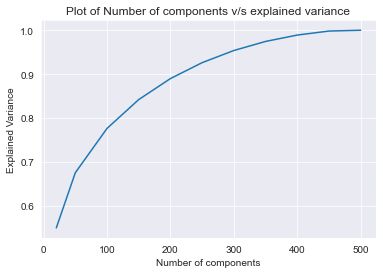

In [1202]:
n_comp = [20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# n_comp = [20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
explained = []
for n in n_comp:
    svd = TruncatedSVD(n_components=n)
    svd.fit(tf_idf_matrix)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(n,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [1269]:
%%time
tsvd = TruncatedSVD(n_components=471)
tf_idf_vectors = tsvd.fit_transform(tf_idf_matrix)
tf_idf_vectors.shape

CPU times: user 20.2 s, sys: 13.7 s, total: 33.9 s
Wall time: 3.74 s


(471, 471)

## FastText training

In [1232]:
tokenized_dataset = [tokenize_text(x) for x in combined_dict.values()]
len(tokenized_dataset)

3251

In [1218]:
%%time
ft_model = FastText(sentences=tokenized_dataset, vector_size=200, window=20, sorted_vocab=True, negative=25, workers=10, sg=1, epochs=80)

CPU times: user 18min 7s, sys: 1.5 s, total: 18min 8s
Wall time: 2min 28s


In [807]:
# ft_model.save('models/fast-text-15-15-70-150.gensim')

In [1219]:
ft_vectors = []
for i, text in tqdm(enumerate(tokenized_dataset), total=len(tokenized_dataset)):
    try:
        vector = ft_model.wv.get_sentence_vector(text)
        ft_vectors.append(vector)
    except Exception as e:
        print(f'Error during vectorizing {i} ')
        ft_vectors.append(np.zeros(ft_model.wv.vector_size))
ft_vectors = np.array(ft_vectors)

100%|██████████| 3251/3251 [00:01<00:00, 2439.71it/s]


In [1220]:
pd.DataFrame(ft_model.wv.most_similar('плита', topn=30))

,0,1
0,настольный,0.785980
1,рабочий,0.773068
2,плитка,0.766677
3,поверхность,0.754764
4,конфорка,0.724125
5,двухконфорочная,0.650142
6,эмалированный,0.644369
7,индукционных,0.643876
8,термостат,0.627590
9,электроплитка,0.622218


## NearestNeighbors

In [1270]:
enumerated_dataset = dict(zip(range(len(train_dict)), train_dict.keys()))
len(enumerated_dataset)

3251

In [1271]:
ref_num_ids = np.array([x for x, y in enumerated_dataset.items() if y in reference_ids])
len(ref_num_ids)

471

In [1272]:
non_ref_num_ids = np.array([x for x, y in enumerated_dataset.items() if y in non_reference_ids])
len(non_ref_num_ids)

2780

In [1273]:
%%time
nn = NearestNeighbors(n_neighbors=1)
# nn.fit(ft_vectors[ref_num_ids])
nn.fit(tf_idf_vectors)

CPU times: user 641 µs, sys: 118 µs, total: 759 µs
Wall time: 566 µs


NearestNeighbors(n_neighbors=1)

In [1274]:
only_non_refs_texts = list(map(lambda x: x[1], filter(lambda x: x[0] in non_reference_ids, combined_dict.items())))
len(only_non_refs_texts)

2780

In [1275]:
%%time
test_vectors = tsvd.transform(tfidf_vectorizer.transform(only_non_refs_texts)) # не надо удали бля
test_vectors.shape

CPU times: user 698 ms, sys: 343 µs, total: 698 ms
Wall time: 697 ms


(2780, 471)

In [1280]:
%%time
ref_neibs = nn.kneighbors(test_vectors)[1]
# ref_neibs = nn.kneighbors(ft_vectors[non_ref_num_ids])[1]
ref_neibs.shape

CPU times: user 5.43 s, sys: 16.4 ms, total: 5.45 s
Wall time: 817 ms


(2780, 1)

In [1284]:
np.sort(nn.kneighbors(test_vectors)[0][:, 0])[::-1][:10]

array([0.9160073 , 0.87488871, 0.87004961, 0.86697574, 0.8667239 ,
       0.86221836, 0.85708163, 0.85654585, 0.85244727, 0.8500676 ])

In [1277]:
real_ref_ids = ref_num_ids[ref_neibs[:, 0]]
real_ref_ids.shape

(2780,)

In [1278]:
matches_count = 0
for i, x in enumerate(non_ref_num_ids):
    prediction_id = real_ref_ids[i]
    reference_uid = train_dict[enumerated_dataset[x]]['reference_id']
    prediction_uid = enumerated_dataset[prediction_id]
    if prediction_uid == reference_uid:
        matches_count += 1
matches_count, matches_count / len(non_ref_num_ids)

(2678, 0.9633093525179857)

In [1279]:
train_dict['767e8aac14292d41']

{'product_id': '767e8aac14292d41',
 'name': 'Стиральная машина Bosch WIW 24340, белый',
 'props': ['Установка\tвстраиваемая',
  'Загрузка\t7  кг',
  'ШхГхВ\t60х57х82   см',
  'Скорость  отжима\t1200 об/мин',
  'Класс   энергопотребления\tA+++',
  'Доп.функции  контроль баланса, выбор температуры стирки, контроль за уровнем пены, сигнал окончания стирки, интеллектуальное управление стиркой, выбор скорости отжима',
  'Защита   от скачков питания, от детей, от протечек'],
 'is_reference': True,
 'reference_id': None}